Understanding the anchor boxes in object detection is tricky. The grid size will determines the denisity of achor boxes.

Density of anchor boxes is not related to image size. But in practice we need to know if our anchor boxes are big enough to indentify the objects. 

We can use following table as ref to determine box size.


| Image Size | Grid Size | Box size|
|--|---|---|
|256, 256| 32, 32 | 256/32 => 8 |
| 256, 256 | 16, 16| 256/16 => 16|
| 256, 256 | 8, 8| 256/8 => 32|
| 192, 192 |32, 32| 192/32 => 6|
| 192, 192 |16, 16|  192/16 => 12|
| 192, 192 | 8, 8| 192/8 => 24|
| 128, 128 | 32,32 | 128/32 => 4|
| 128, 128 | 16,16 | 128/16 => 8|
| 128, 128 | 8,8 | 128/8 => 16|



In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Helper function


In [0]:

import torch
import math
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from matplotlib.pyplot import figure

from cycler import cycler


from fastai import *
from fastai.vision import *

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
#     import pdb; pdb.set_trace()
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

# Lets Print some images

We need some of helper function to create a bounding box with some representation.

Combination of scale & ratio gives different size of boxes in image.

```
>>> ratios = [1/2,1,2]
>>> scales = [.25, .5, 1] 
>>> [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
[[[0.1767766952966369, 0.3535533905932738],
  [0.3535533905932738, 0.7071067811865476],
  [0.7071067811865476, 1.4142135623730951]],
 [[0.25, 0.25], [0.5, 0.5], [1.0, 1.0]],
 [[0.3535533905932738, 0.1767766952966369],
  [0.7071067811865476, 0.3535533905932738],
  [1.4142135623730951, 0.7071067811865476]]]
  ```

size divides the image and creates the grid. 
size decides how far anchor box is placed in the image.

See with one size of (2,2) how boxes are placed.

With in each grid, all the 9 boxes will be placed. 

In [0]:
def show_boxes(boxes, ax=None):
    "Show the `boxes` (size by 4)"
#     _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])
        


# Effect of sparse grid. 

36


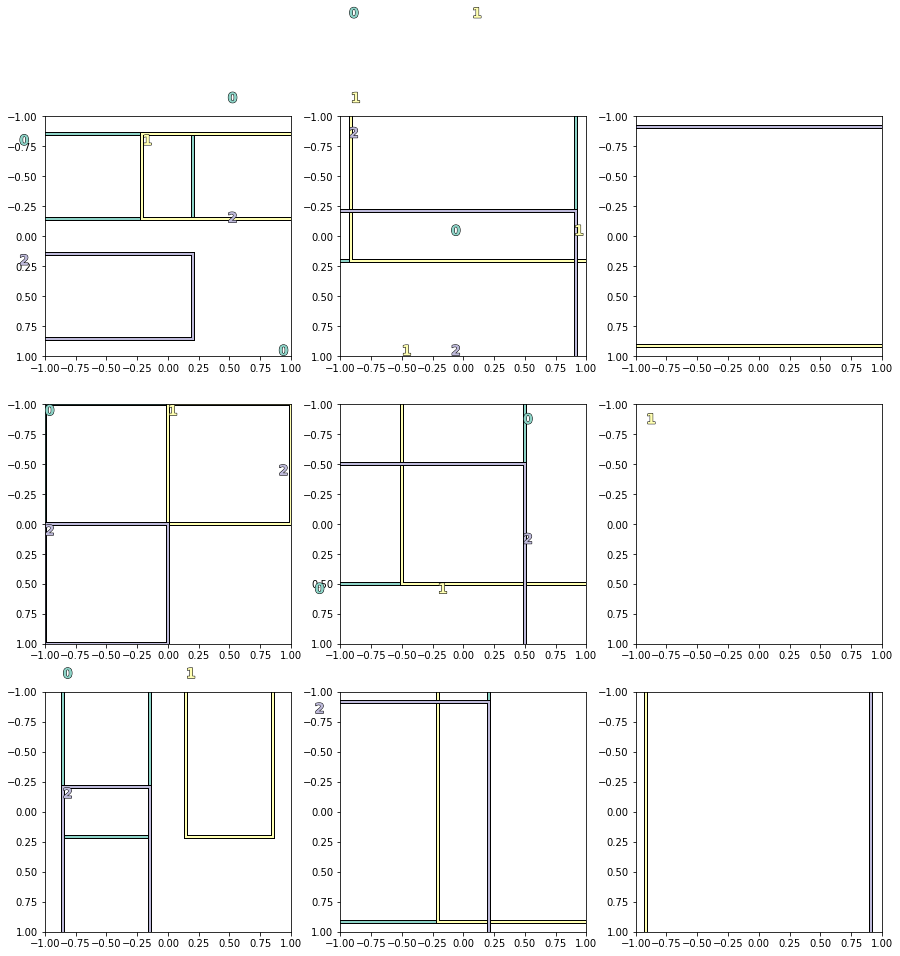

In [4]:
ratios = [1/2,1,2]
scales = [.25, .5, 1] 
sizes = [(2,2)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
print(len(anchors))

box = 9
# figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')
_,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.reshape(-1,9).squeeze()
for b in range(box):
    show_boxes([anchors[i] for i in range(0+b,27+b,9) ] ,axs[b])


# Effect of dense grid. 

If size = 32,32, we will get more dense grid. Dense grid will help to detect more smaller objects.

We are skipping 27 anchors before plotting next anchor.

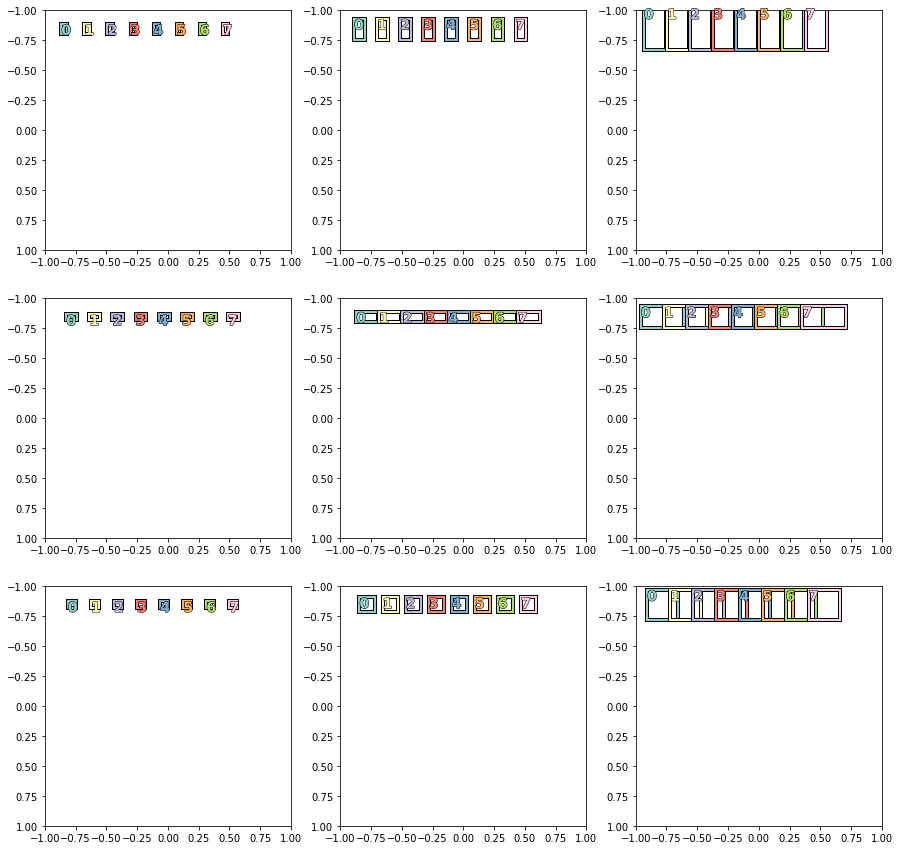

In [5]:
ratios = [1/2,1,2]
scales = [.25, .5, 1] 
sizes = [(32,32)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
ax=None

box = 9
# figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')
_,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.reshape(-1,9).squeeze()
for b in range(box):
    show_boxes([anchors[i] for i in range(600+b,800+b,27) ] ,axs[b])


# Both sparse and dense grid 

If we have 5 different grid size then depending on where we look, we will get different boxes.

Here we are looking at the end of anchors.

12276


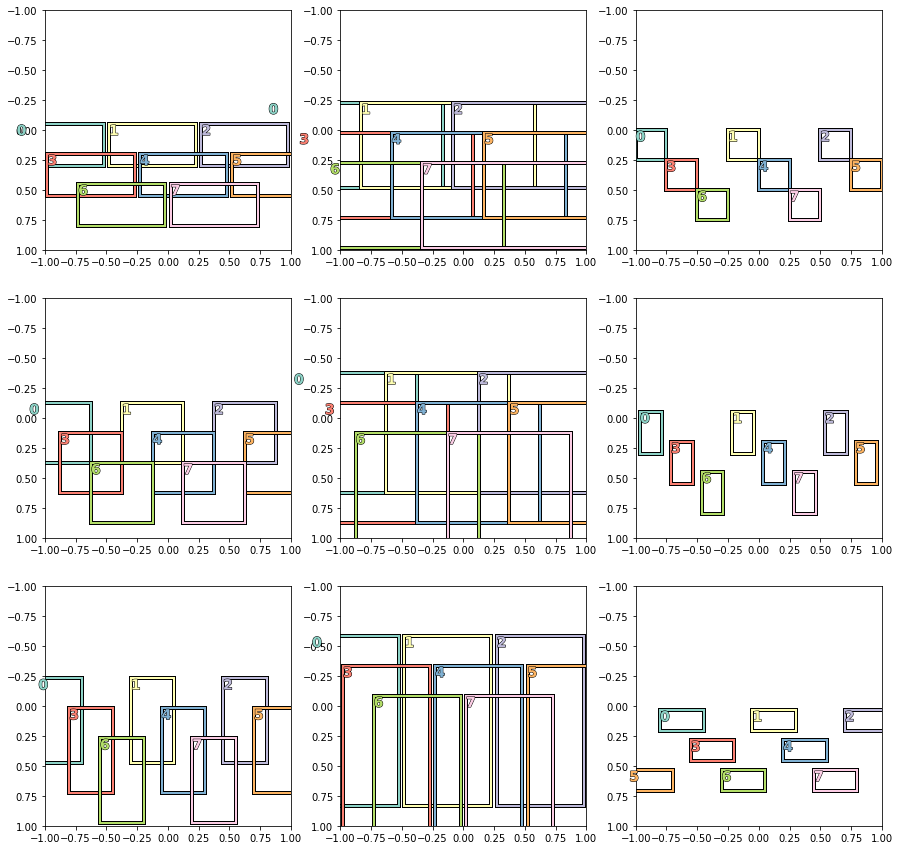

In [6]:
ratios = [1/2,1,2]
scales = [.25, .5, 1] 
sizes = [(2**i,2**i) for i in range(1,6)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
print(len(anchors))

box = 9
_,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.reshape(-1,9).squeeze()
for b in range(box):
    show_boxes([anchors[i] for i in range(11809+b,12000+b,27) ] ,axs[b])


Here we are looking at the start of anchors.

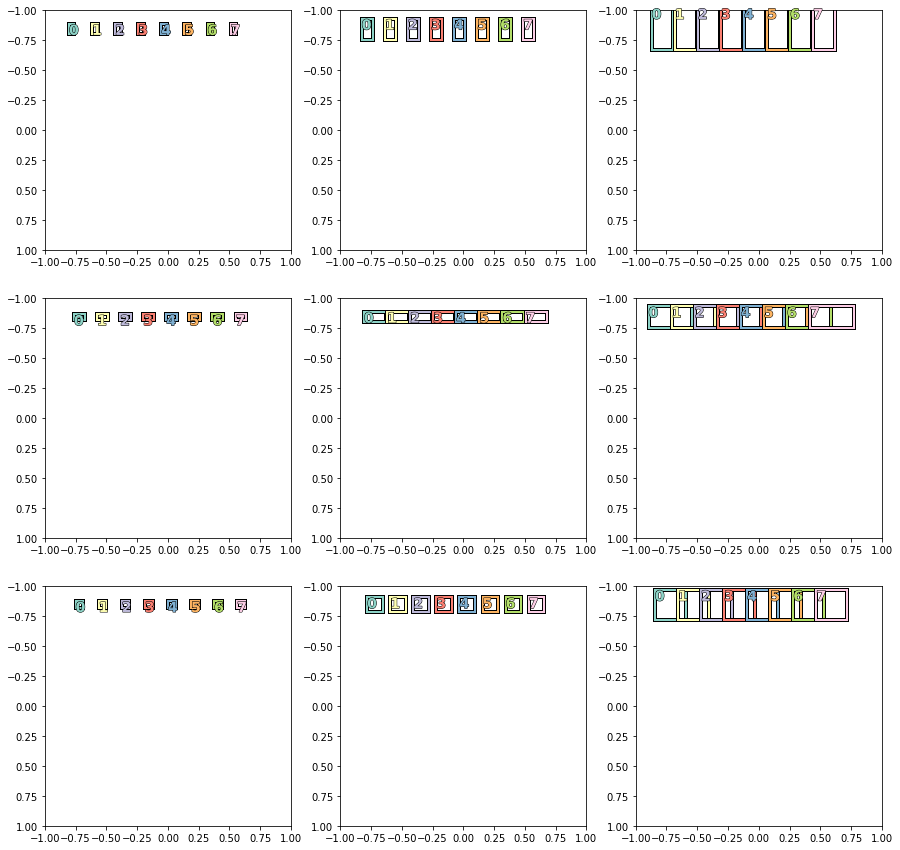

In [7]:
box = 9
_,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.reshape(-1,9).squeeze()
for b in range(box):
    show_boxes([anchors[i] for i in range(609+b,800+b,27) ] ,axs[b])


36
[1000. 1000.]


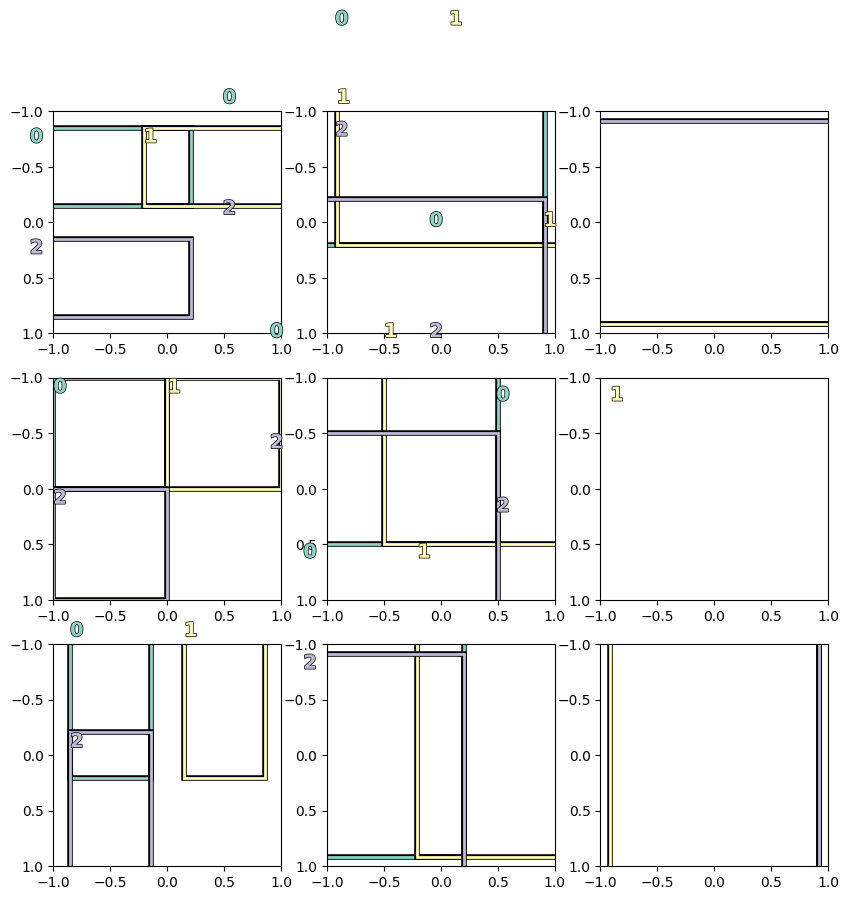

In [8]:
ratios = [1/2,1,2]
scales = [.25, .5, 1] 
sizes = [(2,2)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
print(len(anchors))

box = 9
# figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')
fig,axs = plt.subplots(3,3, squeeze=False, figsize=(10,10), dpi=100)
print(fig.get_size_inches()*fig.dpi)

axs = axs.reshape(-1,9).squeeze()
for b in range(box):
    show_boxes([anchors[i] for i in range(0+b,27+b,9) ] ,axs[b])
    
    

In [0]:
def show_boxes(boxes, ax=None):
    "Show the `boxes` (size by 4)"
    if not ax:
        _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

Anchors going out of boundary are discarded. These anchors box are going out of the frame are generally discarded in object detection. But check again.

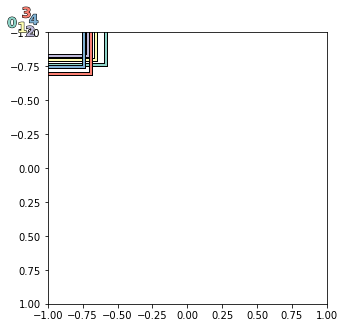

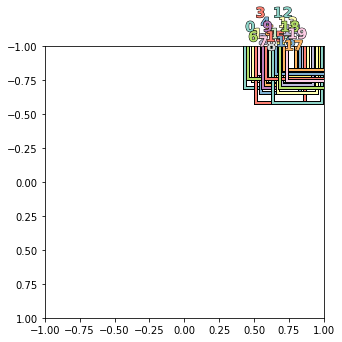

In [10]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
# sizes = [(2**i,2**i) for i in range(2)]
anchors = create_anchors(sizes, ratios, scales)
show_boxes(anchors[:5])
show_boxes(anchors[120:140])

First few 100 boxes are just being discarded. Anchors between this range fits in boundary.
anchors from around 500 fits in the frame.





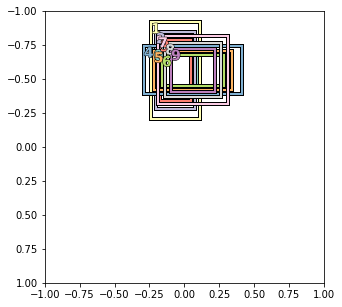

In [11]:
show_boxes(anchors[500:510])

scale used in code. gives better bbox

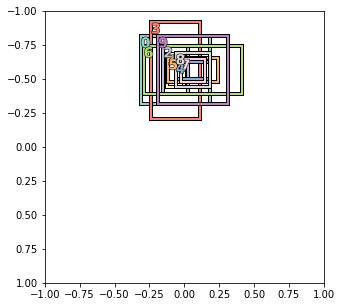

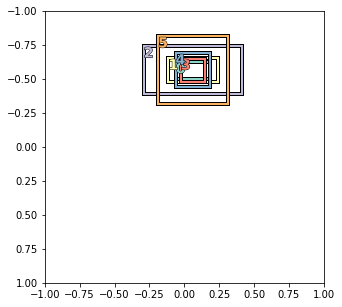

In [12]:
ratios = [1/2,1,2]
scales = [0.35, 0.5, 1]
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
show_boxes(anchors[500:510])
show_boxes(anchors[504:510])


If size is not reversed. we look at bigger bbox first

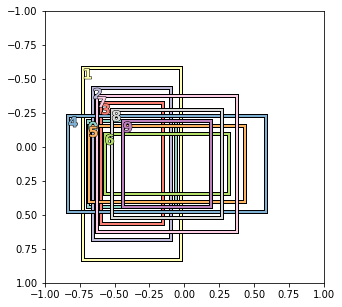

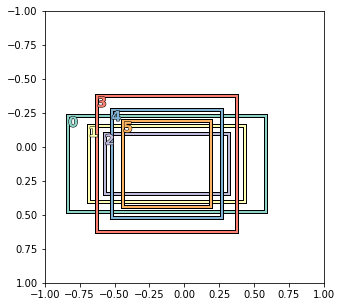

In [13]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
sizes = [(2**i,2**i) for i in range(5)]
# sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
show_boxes(anchors[500:510])
show_boxes(anchors[504:510])       

size is changed to 2 to 32. 


scale is diff from one used in pascal.ipynb in fastai

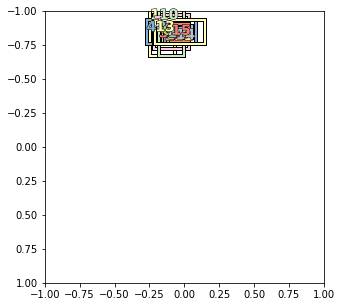

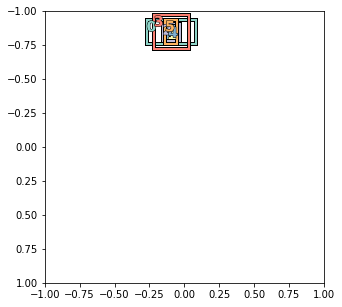

In [14]:
ratios = [1/2,1,2]
scales = [.25, .5, 1,] 
sizes = [(2**i,2**i) for i in range(1,6)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)
show_boxes(anchors[700:716])
show_boxes(anchors[704:710])       

In [15]:
sizes

[(32, 32), (16, 16), (8, 8), (4, 4), (2, 2)]